# UNSUPERVISED LEARNING - PROJECT

#### Olabode James

### Objective: 

To identify different segments in the existing customers based on their spending patterns as well as past interaction with the bank.

### Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

### PROJECT PRELIMINARIES

### Import Libraries

In [41]:
import numpy as np
import pandas as pd

#Visualization Components
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
from matplotlib import cm
sns.set(color_codes=True) # adds a nice background to the graphs
from mpl_toolkits.mplot3d import Axes3D
# In order to enable plotting graphs in Jupyter notebook
%matplotlib inline

#Scalar and normalization components
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#Clustering Algorithm components
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

#Clustering Performance metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import stats

from scipy.spatial.distance import pdist  #Pairwise distribution between data points

#Need to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
custData = pd.read_excel('Credit Card Customer Data.xlsx')

#### Loading and Previewing Data

In [28]:
def dataPurityCheck(df):
    #Check for duplicated entries
    print("Result of duplicates check in data:", df.duplicated().any())
    
    #Check for missing values or null entries in data
    print("Result of missing values or null entries check in data:", df.isnull().any().any())
    if(df.isnull().any().any()):
        print("Breakdown of missing values by attributes: \n", round(df.isna().sum()*100/df.shape[0],2))
    
    #Check for non-real entries which passed null checks like symbols etc
    print("Result of non-real entry check:", df.applymap(np.isreal).any())


In [4]:
custData.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


In [5]:
custData.shape

(660, 7)

In [6]:
custData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
Sl_No                  660 non-null int64
Customer Key           660 non-null int64
Avg_Credit_Limit       660 non-null int64
Total_Credit_Cards     660 non-null int64
Total_visits_bank      660 non-null int64
Total_visits_online    660 non-null int64
Total_calls_made       660 non-null int64
dtypes: int64(7)
memory usage: 36.2 KB


In [7]:
custData.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

INSIGHT: SI_No count does not tally with Customer Key, while key is more unique to identify customers - it is possible some customers have more than one entry in the dataset

In [29]:
#Checking for purity of the data - using three parameters checks - missing values, duplicates and non-real entries
dataPurityCheck(custData)

Result of duplicates check in data: False
Result of missing values or null entries check in data: False
Result of non-real entry check: Sl_No                  True
Customer Key           True
Avg_Credit_Limit       True
Total_Credit_Cards     True
Total_visits_bank      True
Total_visits_online    True
Total_calls_made       True
dtype: bool


INSIGHT: Data looks good, quality check passed. Moving on

In [30]:
custData.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [37]:
#Skewness analysis
custData.skew()

Customer Key           0.051462
Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

Avg_Credit_Limit and Total_visits_online are both right skewed, this would have to be treated according.

INSIGHT: We will need to treat skewness later in the data preparation process

### Project Deliverables

#### 1. Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)

### EDA

In [31]:
#As Serial number(SI no), has no relevance - we can drop the column
custData.drop(['Sl_No'], axis=1, inplace=True)

INSIGHT: Customer Key in the dataset is a unique identification key for each customer to keep track of every unique customer. It does not contribute in understanding customers behaviour for our analysis - but it is unique to each customers, while SI_No identified 660 entries, Customer key stipulates there are actually 655 customers in the dataset - which is more of our interest.

In [32]:
#Creating a new dataframe frame to making customer key unique, while summing along all interaction of that customer with the bank
custData1 = custData.groupby(['Customer Key']).sum()

In [33]:
custData1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Customer Key,,,,,
11265,51000,7,3,2,0
11398,12000,6,5,2,1
11412,19000,2,2,3,4
11466,9000,7,5,0,0
11562,38000,4,3,2,0


In [34]:
custData1.shape

(655, 5)

DEDUCTIONS: THERE IS need to understand the Credit behavior of a customer - however, this will not be possible to see due to the spread on multiple credit cards - customers often collect credit card for multiple reasons and expense needs

In [35]:
custData1['Credit_spend_pattern'] = custData1['Avg_Credit_Limit']/custData1['Total_Credit_Cards']

The attribute Credit_spend_pattern will help answer the question on the Spending pattern of each customer as Total_Credit_Cards or Avg_Credit_Limit will not answer definitely the question.

In [36]:
custData1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern
Customer Key,,,,,,
11265,51000,7,3,2,0,7285.714286
11398,12000,6,5,2,1,2000.000000
11412,19000,2,2,3,4,9500.000000
11466,9000,7,5,0,0,1285.714286
11562,38000,4,3,2,0,9500.000000


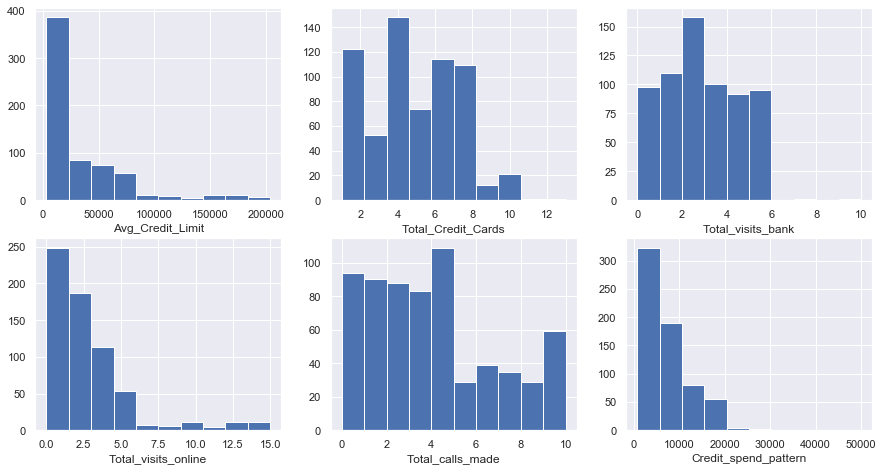

In [38]:
plt.figure(figsize=(15,12))
posHist = 1
for i in custData1.columns:
    plt.subplot(3, 3, posHist)
    plt.hist(custData1[i])
    plt.xlabel(i)
    posHist += 1 

Detailed INSIGHTS: 

1. Most customers in the bank have lower Average Credit Limit
2. Fewer customers tend to visits or interact with the bank online either through website or chatbots
3. Most Customers have less than 5 Credit cards
4. Fewer calls - less than 5, are made by most customers as a means to interact with the bank
5. The current customers of the bank consist of low spenders
6. Compared to making phone calls, customers seems to prefer visiting the bank - consistent with the problem statement, perhaps out of need of realising the online or call channels are not-sufficient to solve customers queries


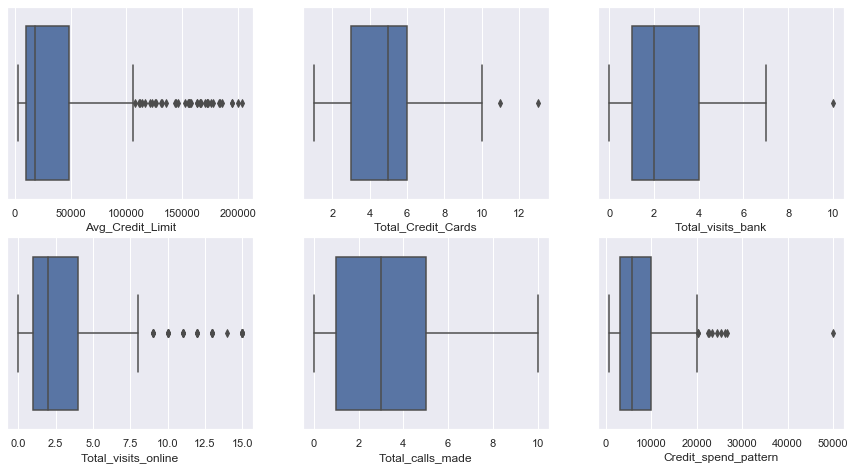

In [40]:
plt.figure(figsize=(15,12))
pos = 1
for i in custData1.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(custData1[i])
    pos += 1 

Detailed INSIGHTS: 

There are outliers in Avg_Credit_Limit and Total_visits_online - This would need to be treated in the data preparation process.

1. A lot of outliers in Credit limit - seems customers like their credit limit raised
2. Visits online and spend pattern are right skewed, implying the current customers prefer to do it less - perhaps a terrible online platform experience - but there are some outliers
3. Visit to bank and calls seems balanced
4. Outliers will need to be treated.

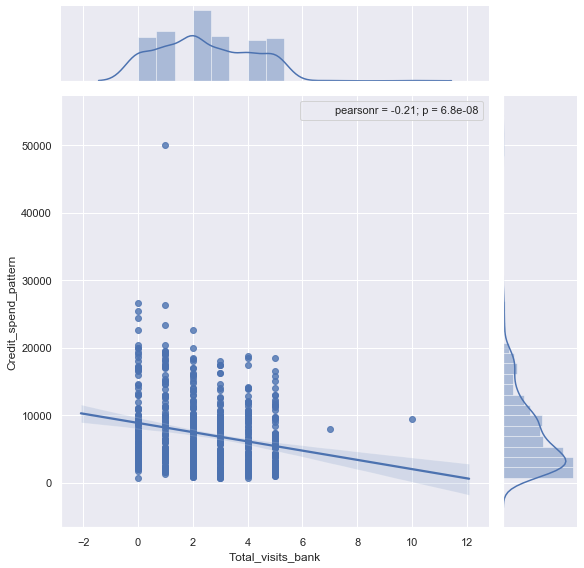

In [42]:
#Checking the spending patterns - and the mode of interaction with the bank, perhaps some insight can be drawn

r1 = sns.jointplot(x="Total_visits_bank",y="Credit_spend_pattern", data=custData1, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

INSIGHT: Heavy spenders visit the bank less, while low spenders visit the bank premises more

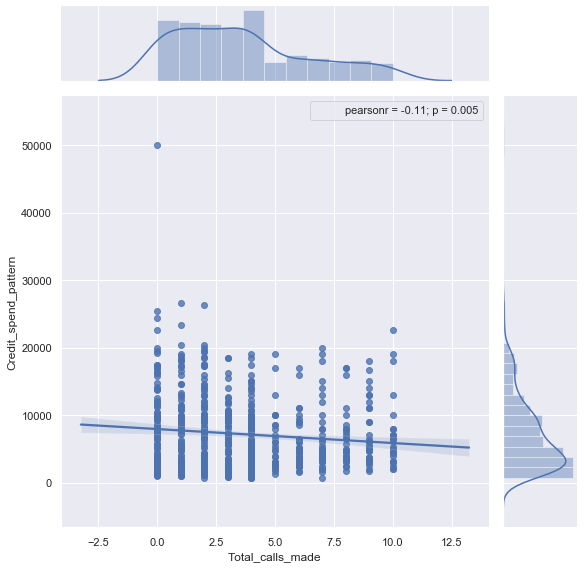

In [43]:
r1 = sns.jointplot(x="Total_calls_made",y="Credit_spend_pattern", data=custData1, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

INSIGHT: Heavy credit spenders make fewer calls, while low spenders make more calls. However, correlation not so strong - perhaps this can be attributed to experience with the call channels

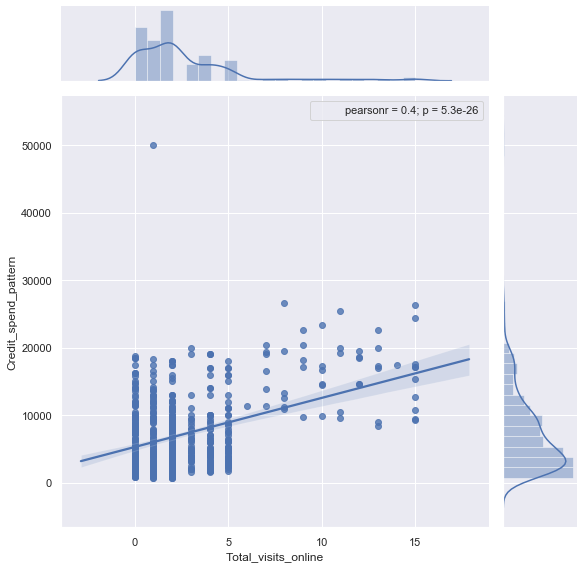

In [44]:
r1 = sns.jointplot(x="Total_visits_online",y="Credit_spend_pattern", data=custData1, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

INSIGHT: Observable strong positive correlation between spending pattern and interaction online. However, a conclusion on this insight would need to be weighed to the total number of lower spenders. Nonetheless good insight.

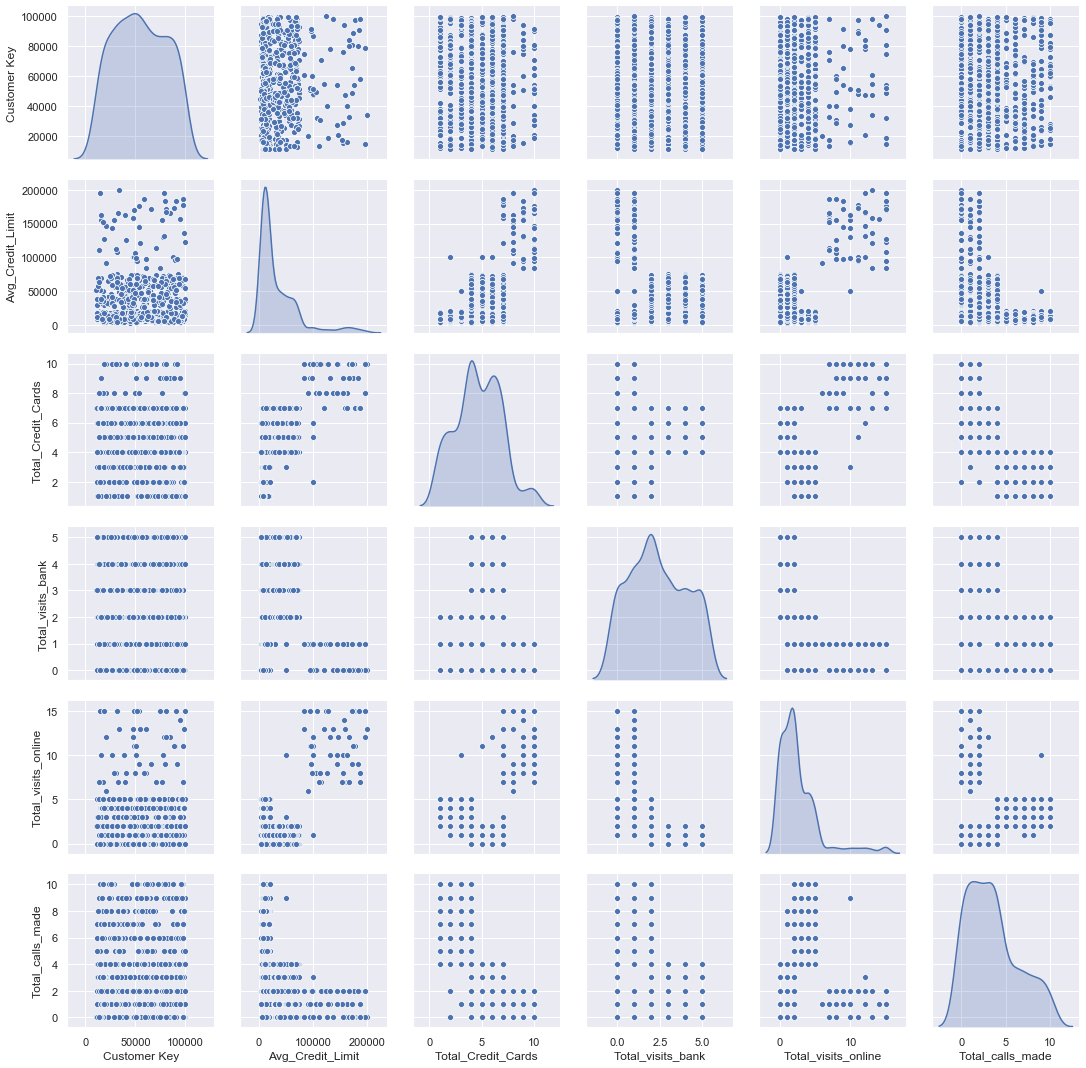

In [47]:
sns.pairplot(custData, diag_kind = 'kde')
plt.show()

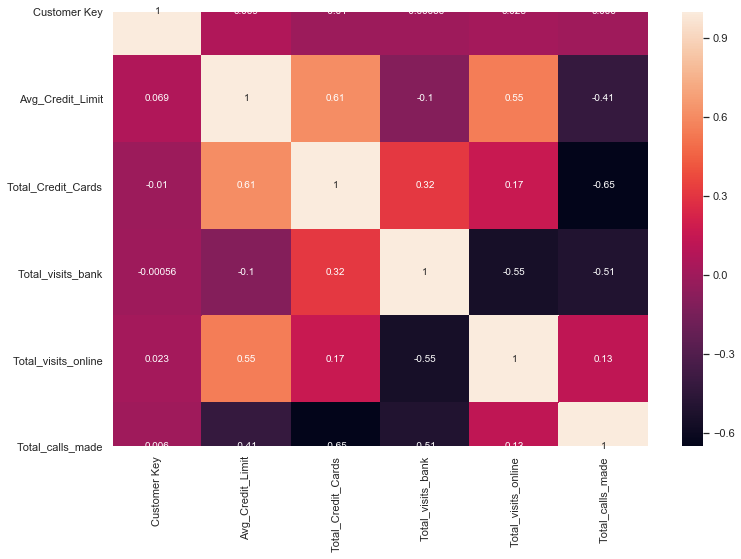

In [48]:
plt.figure(figsize=(12,8))
corr = custData.corr()
sns.heatmap(corr, annot = True)

INSIGHT:
1. There appear to be some correlation between Total_Credit_Cards and Avg_Credit_Limit as well as Total_calls_made - implication, negative between number of credit cards and total calls made.
2. Some negative correlations between Total_visits_bank and Total_visits_online - which is understandable, tallying with earlier conclusion.

In [49]:
#Check for multi-collinearity between features 0 using a 0.80 correlation benchmark Lets check for highly correlated variables
cor= custData.corr()
cor.loc[:,:] = np.tril(cor,k=-1)
cor=cor.stack()
cor[(cor > 0.8) | (cor< -0.8)]

Series([], dtype: float64)

INSIGHT: Empty series, meaning No multi-collinearity between attributes

### Data Preparations before Clustering Analysis

On the customers spending pattern and mode of interaction with the bank - the extracted new feature Credit Spend Pattern will be used to replace Avg_Credit_Limit and Total Credit Cards.

As both seems insufficient independently to answer conclusively HOW a customer is using the Credit cards.
Both will be dropped in further analysis in the revised dataset custData1.

In [50]:
#custDataRev = custData

custData1.drop(['Avg_Credit_Limit'], axis=1, inplace=True)
custData1.drop(['Total_Credit_Cards'], axis=1, inplace=True)

In [51]:
#Skewness analysis
custData1.skew()

Total_visits_bank       0.276800
Total_visits_online     2.214897
Total_calls_made        0.653542
Credit_spend_pattern    1.633361
dtype: float64

In [52]:
custDataRev = custData1

In [53]:
#Avg_Credit_Limit and Total_visits_online are highly skewed - treating right skewness Let us take logaritmic transform

custDataRev['Credit_spend_pattern'] = np.log(custDataRev['Credit_spend_pattern'])
custDataRev['Total_visits_online'] = np.log(custDataRev['Total_visits_online'] +1) 

#necessary for treating 0 data entry present in this attribute

In [ ]:
#for discrete or continuous variables

In [54]:
#Checking new skewness values
custDataRev.skew() #checking if initial objective achieved

Total_visits_bank       0.276800
Total_visits_online     0.166514
Total_calls_made        0.653542
Credit_spend_pattern   -0.265097
dtype: float64

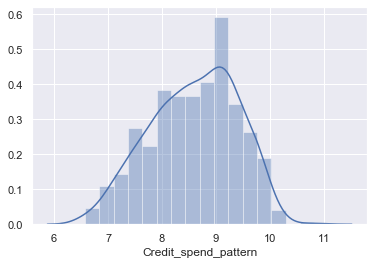

In [55]:
# Right Skewness challenge resolved.
sns.distplot(custDataRev['Credit_spend_pattern'])

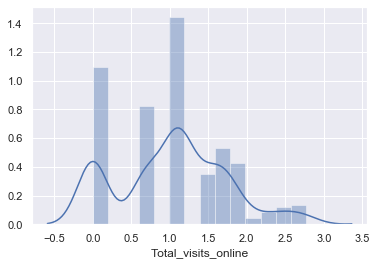

In [56]:
sns.distplot(custDataRev['Total_visits_online'])

Above - Checking that skewness has been treated

In [57]:
columns = custDataRev.columns
custDataRev.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern
Customer Key,,,,
11265,3,1.098612,0,8.893671
11398,5,1.098612,1,7.600902
11412,2,1.386294,4,9.159047
11466,5,0.000000,0,7.159070
11562,3,1.098612,0,9.159047


#### 3. Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)

In [ ]:
#Apply zscore to handle varying scales of variables
#custData.apply(zscore)

In [58]:
#We desire a scaler that will also handle presence of outliers while standardizing the dataset, 
#RobustScaler does that best
rb_scaler = RobustScaler(quantile_range=(25, 75))

In [59]:
custData_scaled = rb_scaler.fit_transform(custDataRev)

In [60]:
scaledDF = pd.DataFrame(data=custData_scaled,columns=columns)
scaledDF.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern
0,0.333333,0.000000,-0.75,0.210878
1,1.000000,0.000000,-0.50,-0.873884
2,0.000000,0.313964,0.25,0.433555
3,1.000000,-1.198978,-0.75,-1.244626
4,0.333333,0.000000,-0.75,0.433555


INSIGHT: Everything looks good. Dataset prepared adequately for clustering analysis.

Customer key also dropped, as the natural index has now been used. But this will be returned to later.

### Clustering Analysis

Variables are now scaled, log transformation to skewed components and outliers treated. Let us now try to create clusters

In [63]:
resultsFinalDF = pd.DataFrame() # This will be used to compare Kmeans to Hierarchical

In [64]:
cluster_range = range(2,15)
cluster_errors = []
silhouette_avg = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(custData_scaled)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    silhouette_avg.append(silhouette_score(custData_scaled, labels))
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors, "Silhouette Avg":silhouette_avg})
clusters_df

,num_clusters,cluster_errors,Silhouette Avg
0,2,723.119255,0.376768
1,3,560.548616,0.402011
2,4,421.816838,0.363717
3,5,365.314484,0.350912
4,6,323.383223,0.299118
5,7,288.018825,0.305207
6,8,261.290702,0.306616
7,9,241.990896,0.294963
8,10,233.908310,0.276101
9,11,219.531896,0.273406


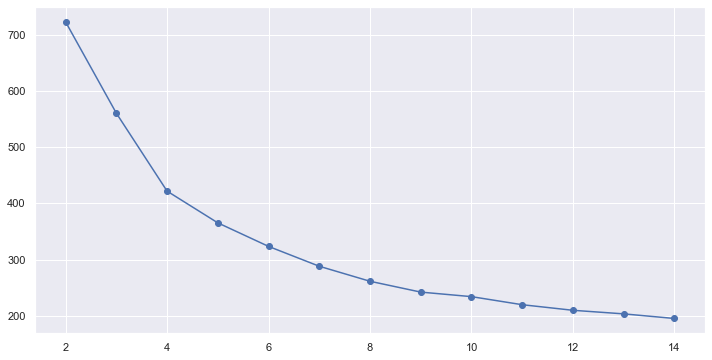

In [65]:
#Plotting the Elbow Curve
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

INSIGHT: We could see the STRONG bend at 4, so let us create 4 clusters but Silhouette avg is telling us, 3 cluster is best.

In [85]:
modelname = "KMeans"
numofClusters = 3

In [87]:
silhouetteScore = clusters_df.iloc[1,2]
print(silhouetteScore)

0.4020110992753934


In [67]:
kmeans3 = KMeans(n_clusters=3, n_init = 5, random_state=12345)
kmeans3.fit(custData_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [70]:
# Check the number of data in each cluster

labels = kmeans3.labels_
counts3 = np.bincount(labels[labels>=0])
print(counts3)

[218 384  53]


In [86]:
groupSize = counts3

In [73]:
predictions = kmeans3.predict(custData_scaled)
#predictions
custData1["group"] = predictions
custData1['group'] = custData1['group'].astype('category')
custData1.dtypes

Total_visits_bank          int64
Total_visits_online      float64
Total_calls_made           int64
Credit_spend_pattern     float64
group                   category
dtype: object

In [75]:
custData1.groupby('group').mean().round(1)

,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern
group,,,,
0,0.9,1.5,7.0,8.6
1,3.5,0.6,2.0,8.5
2,0.7,2.4,1.3,9.7


In [88]:
#Organising results for final presentation
custDataKmeans = custData1.groupby('group').mean().round(1)

In [76]:
# let us check the centers in each group
centroids = kmeans3.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = columns)
centroid_df.transpose()

,0,1,2
Total_visits_bank,-0.350153,0.500000,-0.446541
Total_visits_online,0.428533,-0.563218,1.396126
Total_calls_made,0.994266,-0.244141,-0.433962
Credit_spend_pattern,-0.063372,-0.158431,0.866013


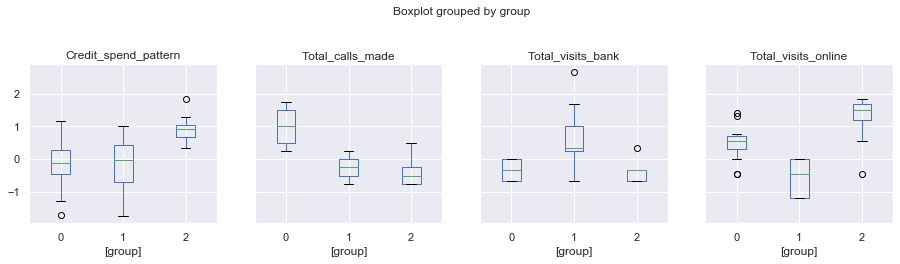

In [77]:
# Visualize each group
scaledDF["group"] = predictions
scaledDF.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10));

DETAILED INSIGHT From Above Steps: 
    
    THERE ARE THREE GROUPS OF CUSTOMERS, Which will be classifed into 
    Group 0 = The medium Credit spender customers
    Group 1 = The low Credit spender customers
    Group 2 = The Heavy Credit spender customers
    
Group Characteristics - 
Group 0: Average Credit Customers
    Second majority customers group, consist of people likely to have close to average Credit spend pattern but are likely to use the phone call channel to interact with the bank more, sometimes uses the online platform to interact but not strongly compelled to visit the bank.
    To market to this group of customers, the bank will need to strongly use automated marketing caller tunes as well as use the online platform.
    
Group 1: Below Average Credit Customers
    The current majority of the bank customers - this group use credit less than other groups and is the majority visiting the bank premises.
    To upsell marketing to this group to use more credit, the bank will need to use in-bank premises marketing tools like flyers, banners, physical marketing agents and perhaps physical promotional gifts
    
Group 2: Heavy Credit Customers
    The least group in the current pool of the bank customers, interact mostly with the bank through the online platforms and are less like to call the bank or visit any branch
    To sell more Credit products to this group, the bank will need to utilise the current online platforms.

Text(0.5, 0.92, '3D Plot of KMeans Clustering')

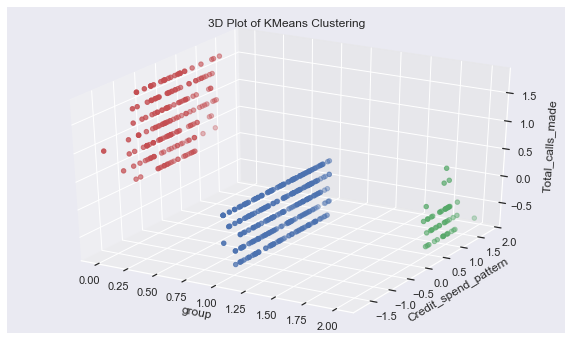

In [80]:
color_map={0:'r',1:'b',2:'g'}
label_color = [color_map[l] for l in kmeans3.labels_]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaledDF["group"], scaledDF["Credit_spend_pattern"], scaledDF["Total_calls_made"], c=label_color)
ax.set_xlabel("group")
ax.set_ylabel("Credit_spend_pattern")
ax.set_zlabel("Total_calls_made")
ax.set_title('3D Plot of KMeans Clustering')

Text(0.5, 0.92, '3D Plot of KMeans Clustering')

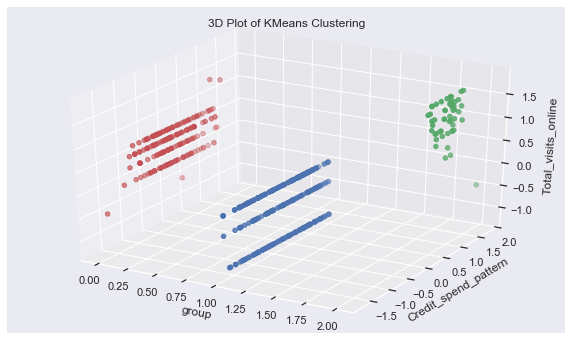

In [82]:
color_map={0:'r',1:'b',2:'g'}
label_color = [color_map[l] for l in kmeans3.labels_]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaledDF["group"], scaledDF["Credit_spend_pattern"], scaledDF["Total_visits_online"], c=label_color)
ax.set_xlabel("group")
ax.set_ylabel("Credit_spend_pattern")
ax.set_zlabel("Total_visits_online")
ax.set_title('3D Plot of KMeans Clustering')

Text(0.5, 0.92, '3D Plot of KMeans Clustering')

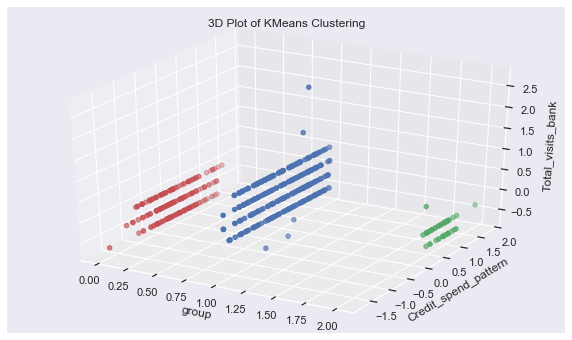

In [83]:
color_map={0:'r',1:'b',2:'g'}
label_color = [color_map[l] for l in kmeans3.labels_]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaledDF["group"], scaledDF["Credit_spend_pattern"], scaledDF["Total_visits_bank"], c=label_color)
ax.set_xlabel("group")
ax.set_ylabel("Credit_spend_pattern")
ax.set_zlabel("Total_visits_bank")
ax.set_title('3D Plot of KMeans Clustering')

INSIGHT: Consistent interpretation as earlier stated.

In [92]:
resultsFinalDF = pd.DataFrame({"Cluster Model":[modelname],"No. of Groups": [numofClusters], "Group 0": groupSize[0], "Group 1":groupSize[1], "Group 2": groupSize[2],"Silhouette Avg": [silhouetteScore] })
resultsFinalDF

,Cluster Model,No. of Groups,Group 0,Group 1,Group 2,Silhouette Avg
0,KMeans,3,218,384,53,0.402011


#### 4. Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)

In [93]:
custDataRev2 = custData1.drop(['group'], axis=1)

In [96]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

results = []
linkages = ['single','average','complete','centroid', 'ward']
for links in linkages:
    Z = linkage(custData_scaled, metric='euclidean', method=links)
    c, coph_dists = cophenet(Z , pdist(custData_scaled))
    results.append([links,c])

resultDF = pd.DataFrame(results, columns=["Linkage Type","Cophenet Index"])

In [97]:
resultDF

,Linkage Type,Cophenet Index
0,single,0.490702
1,average,0.746706
2,complete,0.597812
3,centroid,0.732629
4,ward,0.692276


INSIGHT: Average linkage showed the highest Cophenet coefficient at 0.747 which implies alignment with the sample data. This linkage type will be used for our hierarchical clustering.

In [99]:
clusters_df = pd.DataFrame()
results = []
cluster_range = range(2,15)
silhouette_avg = []
for num_clusters in cluster_range:
    model = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean',  linkage='average')
    model.fit(custData_scaled)
    groupings = model.labels_
    silhouette_avg.append(silhouette_score(custData_scaled, groupings))
    #results.append([num_clusters,silhouette_avg])

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "Silhouette Avg": silhouette_avg})
clusters_df

,num_clusters,Silhouette Avg
0,2,0.360516
1,3,0.284112
2,4,0.228447
3,5,0.356696
4,6,0.310739
5,7,0.276299
6,8,0.273071
7,9,0.231406
8,10,0.233863
9,11,0.269195


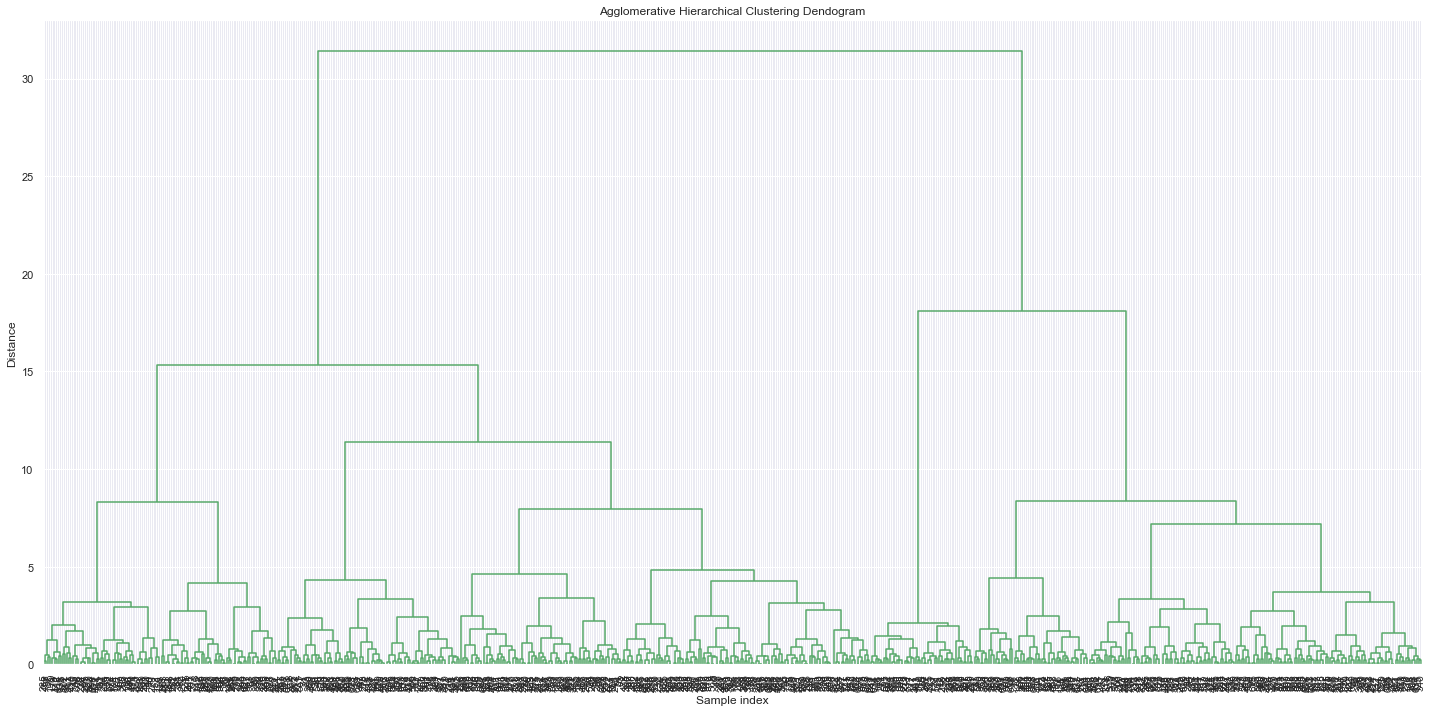

In [98]:
plt.figure(figsize=(20, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=600,  leaf_font_size=10. )
plt.tight_layout()

INSIGHT: The Silhouette Avg for 2 clusters is the best grouping using hierarchical clustering, this is also deducible from the dendrogram when a cut is made at distance 20 - the arm for the a possible third arm is smaller and less representative as much as that from two grouping.
    
Also, a possible cut at distance 10 looks like a grouping as well resulting in a possible five clusters.

Nonetheless, a two group cluster does not look capable of providing as much granularity as would be desired to understand spend pattern and interaction with bank. So we will keep to using five clusters considering closeness of Silhouette Coefficient

In [118]:
modelname = "Hierarchical-Agglomerative"
numofClusters = 5

model = AgglomerativeClustering(n_clusters=numofClusters, affinity='euclidean',  linkage='average')
model.fit(custData_scaled)
custData1['group'] = model.labels_

In [119]:
# Check the number of data in each cluster

groupings = model.labels_
counts2 = np.bincount(groupings[groupings>=0])
print(counts2)

[211 393  49   1   1]


In [128]:
groupSize2 = counts2

### INSIGHT: For purpose of deployment, group 4 and 5 may be placed into the closest group rather than allowed to stand alone as each might be outlier behaviour as against being representative of group behaviour or pattern.

In [129]:
silhouetteScore = silhouette_score(custData_scaled, groupings)

In [130]:
silhouetteScore

0.3566962740534284

In [121]:
custData1.head(10)

,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern,group
Customer Key,,,,,
11265,3,1.098612,0,8.893671,1
11398,5,1.098612,1,7.600902,1
11412,2,1.386294,4,9.159047,1
11466,5,0.000000,0,7.159070,1
11562,3,1.098612,0,9.159047,1
11596,4,0.000000,2,8.006368,1
11602,1,1.791759,4,7.600902,0
11698,3,0.000000,4,8.354674,1
11734,5,0.000000,2,8.329141,1


In [117]:
custData1.groupby(["group"]).mean().round(1)

,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_spend_pattern
group,,,,
0,0.9,1.5,7.1,8.6
1,3.4,0.6,2.1,8.5
2,0.7,2.5,1.1,9.6
3,10.0,1.1,4.0,9.2
4,1.0,0.7,0.0,10.8


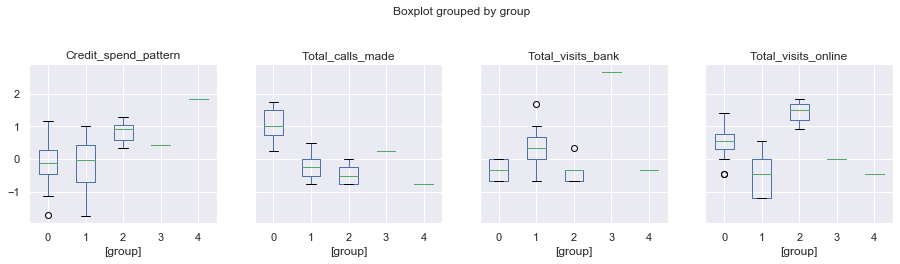

In [125]:
# Visualize each group using boxplot

#predictions = model.predict(custData_scaled)
scaledDF["group"] = model.labels_
scaledDF.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10));

In [126]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Total_calls_made",y="Credit_spend_pattern", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Total_visits_bank",y="Credit_spend_pattern", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Total_visits_online",y="Credit_spend_pattern", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

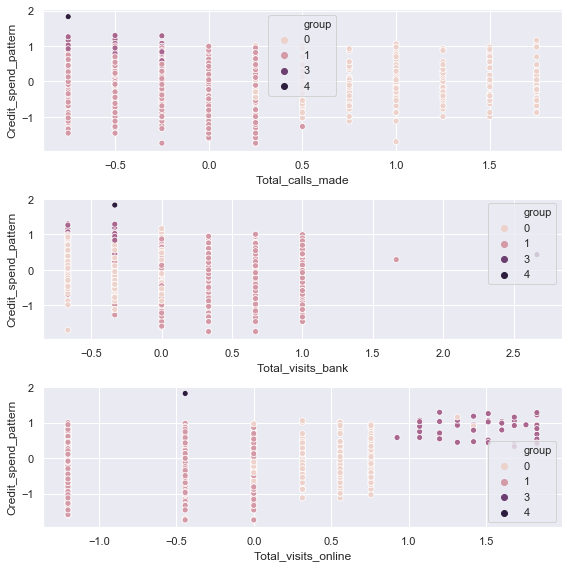

In [127]:
scatters(scaledDF,'group')

DETAILED INSIGHT: 
    Like Kmeans, there are overall three spending behaviours utilizing different means of interaction with the bank.
    Group 0 - The average credit customer relying more on Calls to interact with the bank
    Group 1 - The below average credit customer with tendency to interact with the bank by visiting the branch location
    Group 2 - The heavy credit customers with capacity to use Online channels as means of interaction.
    Group 3 - An outlier heavy credit customer visiting the bank branch - reason for this outlier behaviour need further justification
    Group 4 - An outlier heavy credit customer not using effectively any of the provided means of interaction with the bank - this outlier behaviour also need to be examined further 
    
Group 3 and 4, can be placed effectively in Group 2. Which will make observed pattern similar to Kmeans clustering earlier.

In [132]:
#Place in finalresults dataframe

resultsFinalDF.loc[1] = [modelname, numofClusters, groupSize2[0], groupSize2[1], groupSize2[2]+2, silhouetteScore]
resultsFinalDF

,Cluster Model,No. of Groups,Group 0,Group 1,Group 2,Silhouette Avg
0,KMeans,3,218,384,53,0.402011
1,Hierarchical-Agglomerative,5,211,393,51,0.356696


#### 5. Calculate average silhouette score for both methods. (5 marks)

In [133]:
resultsFinalDF

,Cluster Model,No. of Groups,Group 0,Group 1,Group 2,Silhouette Avg
0,KMeans,3,218,384,53,0.402011
1,Hierarchical-Agglomerative,5,211,393,51,0.356696


### INSIGHT: KMeans gave the highest Silhouette Score

INSIGHT: Highest Silhouette Index is for Kmeans, which implies the best clustering from our dataset which is consistent with the results from Kmeans however with a slightly lower Silhouetter index compared to Kmeans in Agglomerative.

#### 6. Compare K-means clusters with Hierarchical clusters. (5 marks)

In [134]:
resultsFinalDF

,Cluster Model,No. of Groups,Group 0,Group 1,Group 2,Silhouette Avg
0,KMeans,3,218,384,53,0.402011
1,Hierarchical-Agglomerative,5,211,393,51,0.356696


DEDUCTIONS:
    
    The results of the both clustering methods is comparable. While Hierarchical was able to identify outliers and thus influenced by such while forming clusters, Kmeans was however able to place more priority on group behaviour as against being influenced.
    
    The Group 0 - Average credit spender with tendency to use the Call contact channel is higher in Kmeans.
    The Group 1 - Below average credit spender with tendency to visit bank branch is higher in Hierarchical
    The Group 2 - The heavy Credit spender with tendency to use the online Channel is higher in Kmeans
    
    Results are however comparable.
    
    Silhouetter Score is higher for Kmeans.

#### 7. Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)

Conclusions: 
    
    Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

    Key Questions:
        1. How many different segments of customers are there? 
        ANSWER: THERE ARE THREE PRINCIPAL CUSTOMER GROUPS
        2. How are these segments different from each other?
        
            Group 0 = The medium Credit spender customers
            Group 1 = The low Credit spender customers
            Group 2 = The Heavy Credit spender customers
    
        Group Characteristics - 
            Group 0: Average Credit Customers
                Second majority customers group, consist of people likely to have close to average Credit spend pattern but are likely to use the phone call channel to interact with the bank more, sometimes uses the online platform to interact but not strongly compelled to visit the bank.
                To market to this group of customers, the bank will need to strongly use automated marketing caller tunes as well as use the online platform.
    
            Group 1: Below Average Credit Customers
                The current majority of the bank customers - this group use credit less than other groups and is the majority visiting the bank premises.
                To upsell marketing to this group to use more credit, the bank will need to use in-bank premises marketing tools like flyers, banners, physical marketing agents and perhaps physical promotional gifts
    
            Group 2: Heavy Credit Customers
                The least group in the current pool of the bank customers, interact mostly with the bank through the online platforms and are less like to call the bank or visit any branch
                To sell more Credit products to this group, the bank will need to utilise the current online platforms.
        
        3. What are your recommendations to the bank on how to better market to and service these customers?
        
                The bank need to improve on its online banking experience as it is the least use channel of contact by the banks customers.
            
                The call center is the most used channel on contact, improvement might not be necessary.
                
                The bank premises appeals to customers too but not as much as the Call centers.